In [1]:
import cv2
from ultralytics import YOLO
from PIL import Image, ImageDraw

import yaml
import pandas as pd
import os
import plotly.express as px

import matplotlib.pyplot as plt
import numpy as np

model = YOLO('2025_03_YOLOv11s_50.pt')

## Описание модели

### Модель YOLO (You Only Look Once) - одна из простейших и самых быстрых нейросетевых моделей для задачи детекции объектов.

In [11]:
model.names

{0: 'cattle', 1: 'human', 2: 'vehicle'}

Модель обучена на детекцию по трем классам:
- 0: 'cattle' - Крупные животные
- 1: 'human' - Люди
- 2: 'vehicle' - Автомобильная техника различных типов (Грузовые, легковые, автобусы, трактора)

In [15]:
model.info()

YOLO11s summary: 319 layers, 9,428,953 parameters, 0 gradients, 21.6 GFLOPs


(319, 9428953, 0, 21.5527936)

Данная модель обучалась на архитектуре модели версии YOLO11s

## Подготовка датасета

### Сбор данных

- Для формирования датасета, предназначенного исключительно для тестирования модели, были взяты видеозаписи, полученные при запуске ПАК 09.06.2025;
- Видеозаписи были разобраны по кадрам (2 кадра в секунду);
- Изображения не содержащие объектов в кадре были удалены из выборки, количество изображений составило 7256;
- Изображения были размечены при помощи Computer Vision Annotation Tool (CVAT) — это веб-инструмент для аннотирования изображений и видео с открытым исходным кодом. Используется для разметки данных под задачи компьютерного зрения;
- Количество размеченных изображений для выборки, предназначенной для оценки модели, составило 1782.

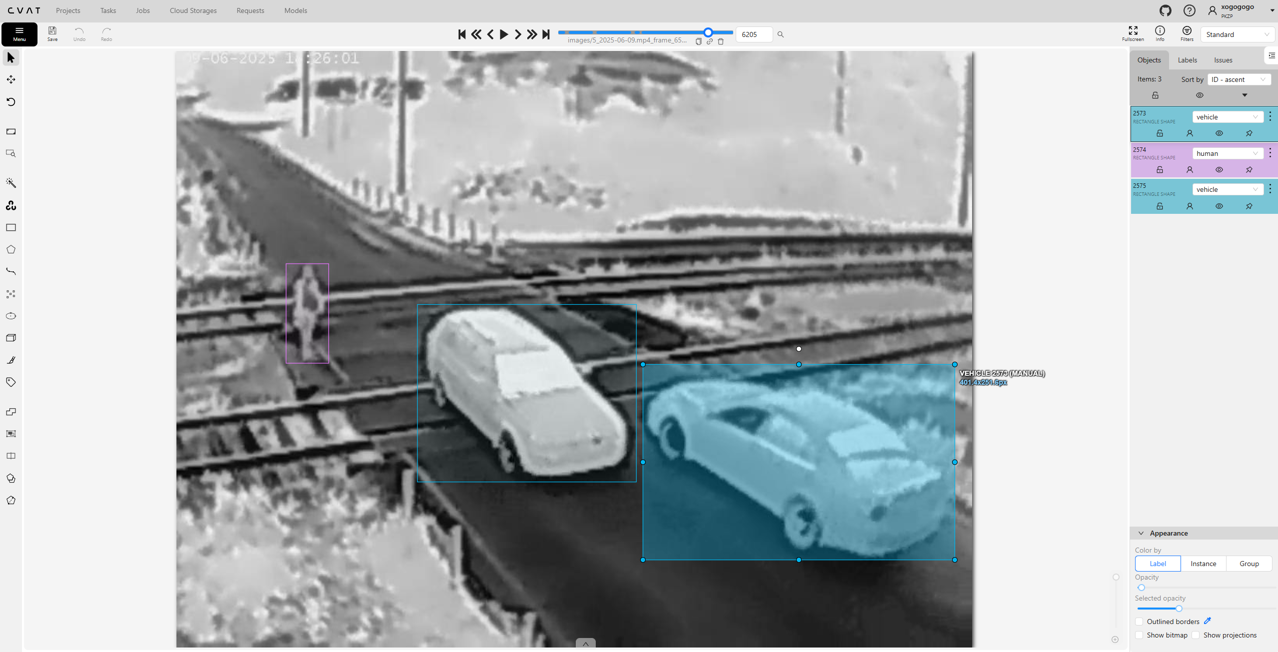

In [4]:
image = Image.open('runs/detect/val2/CVAT.png')
scale = 0.5
new_width = int(image.width * scale)
new_height = int(image.height * scale)

resized_image = image.resize((new_width, new_height))

display(resized_image)

- Показан пример разметки изображения с использованием **CVAT**

### Удаление изображения без разметки

- Оставляем только размеченные изображения (1782)

In [5]:
def check_and_clean_directories(labels_dir, images_dir):
    labels_files = set(os.listdir(labels_dir))
    images_files = set(os.listdir(images_dir))

    labels_names = {os.path.splitext(file)[0] for file in labels_files if file.endswith('.txt')}
    images_names = {os.path.splitext(file)[0] for file in images_files if file.endswith('.jpg')}

    labels_without_pair = labels_names - images_names
    images_without_pair = images_names - labels_names

    for label in labels_without_pair:
        file_path = os.path.join(labels_dir, f"{label}.txt")
        os.remove(file_path)

    for image in images_without_pair:
        file_path = os.path.join(images_dir, f"{image}.jpg")
        os.remove(file_path)

labels_dir = 'A:/PythonProjects/RAILROAD/dataset/test/labels'
images_dir = 'A:/PythonProjects/RAILROAD/dataset/test/images'
check_and_clean_directories(labels_dir, images_dir)

### Примеры и статистика

In [6]:
names = {0: 'cattle', 1: 'human', 2: 'vehicle'}
colors = {label: list(np.random.random(size=3) * 256) for i, label in enumerate(set([int(key) for key in names.keys()]))}

In [7]:
# Отрисовка разметки для изображения
def draw_bbox(image_path, annotation_path, names):
    image = cv2.imread(image_path)

    if image is None:
        print("Изображение не найдено")
        return

    with open(annotation_path, 'r') as annotation_file:
        annotations = annotation_file.readlines()

    for annotation in annotations:
        label, x_center, y_center, width, height = annotation.strip().split()
        x_center, y_center, width, height = map(float, [x_center, y_center, width, height])

        x = int(x_center * image.shape[1] - width * image.shape[1] / 2)
        y = int(y_center * image.shape[0] - height * image.shape[0] / 2)
        box_width = int(width * image.shape[1])
        box_height = int(height * image.shape[0])   
        color = list(colors[int(label)])
        pt1 = (x, y)
        pt2 = (x + box_width, y + box_height)
        cv2.rectangle(image, pt1, pt2, color, 2)
        name = str(label) + ": " + str(names[int(label)])
        cv2.putText(image, name, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.imshow(image)
    plt.show()

#### Примеры размеченных изображений

- Датасет содержит изображения, как с камеры четной стороны, так и с камеры нечетной стороны, имитирующие холодную погоду, когда объекты теплее дорожного полотна

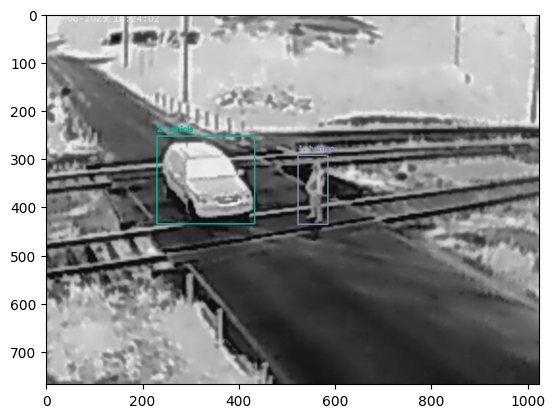

In [9]:
draw_bbox('A:/PythonProjects/RAILROAD/dataset/test/images/5_2025-06-09.mp4_frame_401_time_188.59s.jpg',
          'A:/PythonProjects/RAILROAD/dataset/test/labels/5_2025-06-09.mp4_frame_401_time_188.59s.txt',
          names)

- Датасет содержит изображения, имитирующие жаркую погоду, когда объекты холоднее дорожного полотна

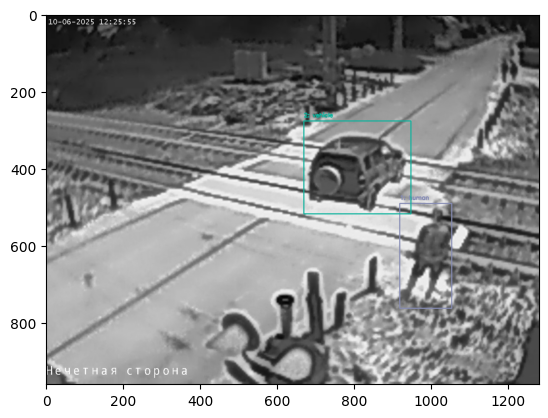

In [8]:
draw_bbox('A:/PythonProjects/RAILROAD/dataset/test/images/12_2025-06-10.mp4_frame_270_time_127.61s.jpg',
          'A:/PythonProjects/RAILROAD/dataset/test/labels/12_2025-06-10.mp4_frame_270_time_127.61s.txt',
          names)

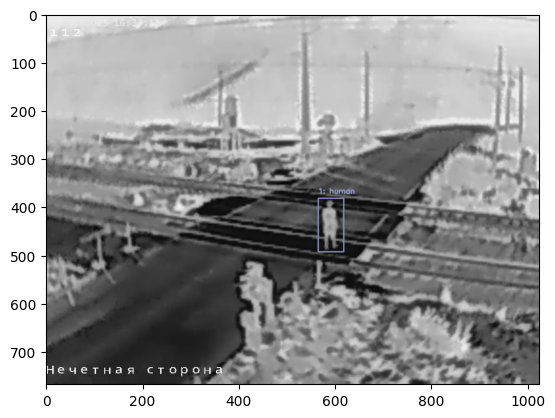

In [10]:
draw_bbox('A:/PythonProjects/RAILROAD/dataset/test/images/16_2025-06-10.mp4_frame_103_time_48.20s.jpg',
          'A:/PythonProjects/RAILROAD/dataset/test/labels/16_2025-06-10.mp4_frame_103_time_48.20s.txt',
          names)

#### Статистика по распределению классов на размеченных изображениях

In [9]:
# Сбор статистики
def check_labels(folder):
    pkzp_labels = {
        'Файл': [],
        'Папка': [],
        'Класс': [],
        'bbox': []
    }
    for filename in os.listdir(f'{folder}/labels'):
        if filename.endswith('.txt'):
            file_path = os.path.join(f'{folder}/labels', filename)
            with open(file_path, 'r', encoding='utf-8') as file:
                lines = file.readlines()
                if not lines:
                    pkzp_labels['Файл'].append(filename)
                    pkzp_labels['Папка'].append(folder.split('/')[-1])
                    pkzp_labels['Класс'].append(None)
                    pkzp_labels['bbox'].append(0)
                else:
                    for line in lines:
                        pkzp_labels['Файл'].append(filename)
                        pkzp_labels['Папка'].append(folder.split('/')[-1])
                        pkzp_labels['Класс'].append(line.split(' ')[0])
                        pkzp_labels['bbox'].append(len(line.split(' ')))

    pkzp_labels = pd.DataFrame(pkzp_labels)
    return pkzp_labels

pkzp_labels = check_labels('A:/PythonProjects/RAILROAD/dataset/test')
pkzp_labels.head()

Файл Папка Класс  bbox
0     10_2025-06-09.mp4_frame_0_time_0.00s.txt  test     1     5
1     10_2025-06-09.mp4_frame_0_time_0.00s.txt  test     1     5
2  10_2025-06-09.mp4_frame_100_time_47.51s.txt  test     2     5
3    10_2025-06-09.mp4_frame_10_time_4.75s.txt  test     1     5
4    10_2025-06-09.mp4_frame_10_time_4.75s.txt  test     1     5

In [10]:
pkzp_labels_gr = pkzp_labels.groupby(['Папка', 'Класс'], as_index=False).size().sort_values('Класс', ascending=True)
pkzp_labels_gr['Класс_name'] = pkzp_labels_gr['Класс'].apply(lambda x: names[int(x)])
pkzp_labels_gr

Папка Класс  size Класс_name
0  test     1  2410      human
1  test     2   629    vehicle

In [11]:
fig_class_1 = px.histogram(
    data_frame=pkzp_labels_gr,
    y='size',
    x='Класс_name',
    color='Папка',
    text_auto=True
    )

fig_class_1.update_layout(title_text='<b>Распределение меток в данных</b>', title_x=0.5, height=500, yaxis = {"title": 'Количество меток'})
fig_class_1.show()

- Выборка из 1782 содержит 2410 разметок для класса "human" и 629 разметок для класса "vehicle"

## Валидация модели на тестовом датасете

In [ ]:
results = model.val(data='A:/PythonProjects/RAILROAD/dataset/pkzp_test.yaml', split='test')

display(results)

### Сравнение разметки и результата работы модели

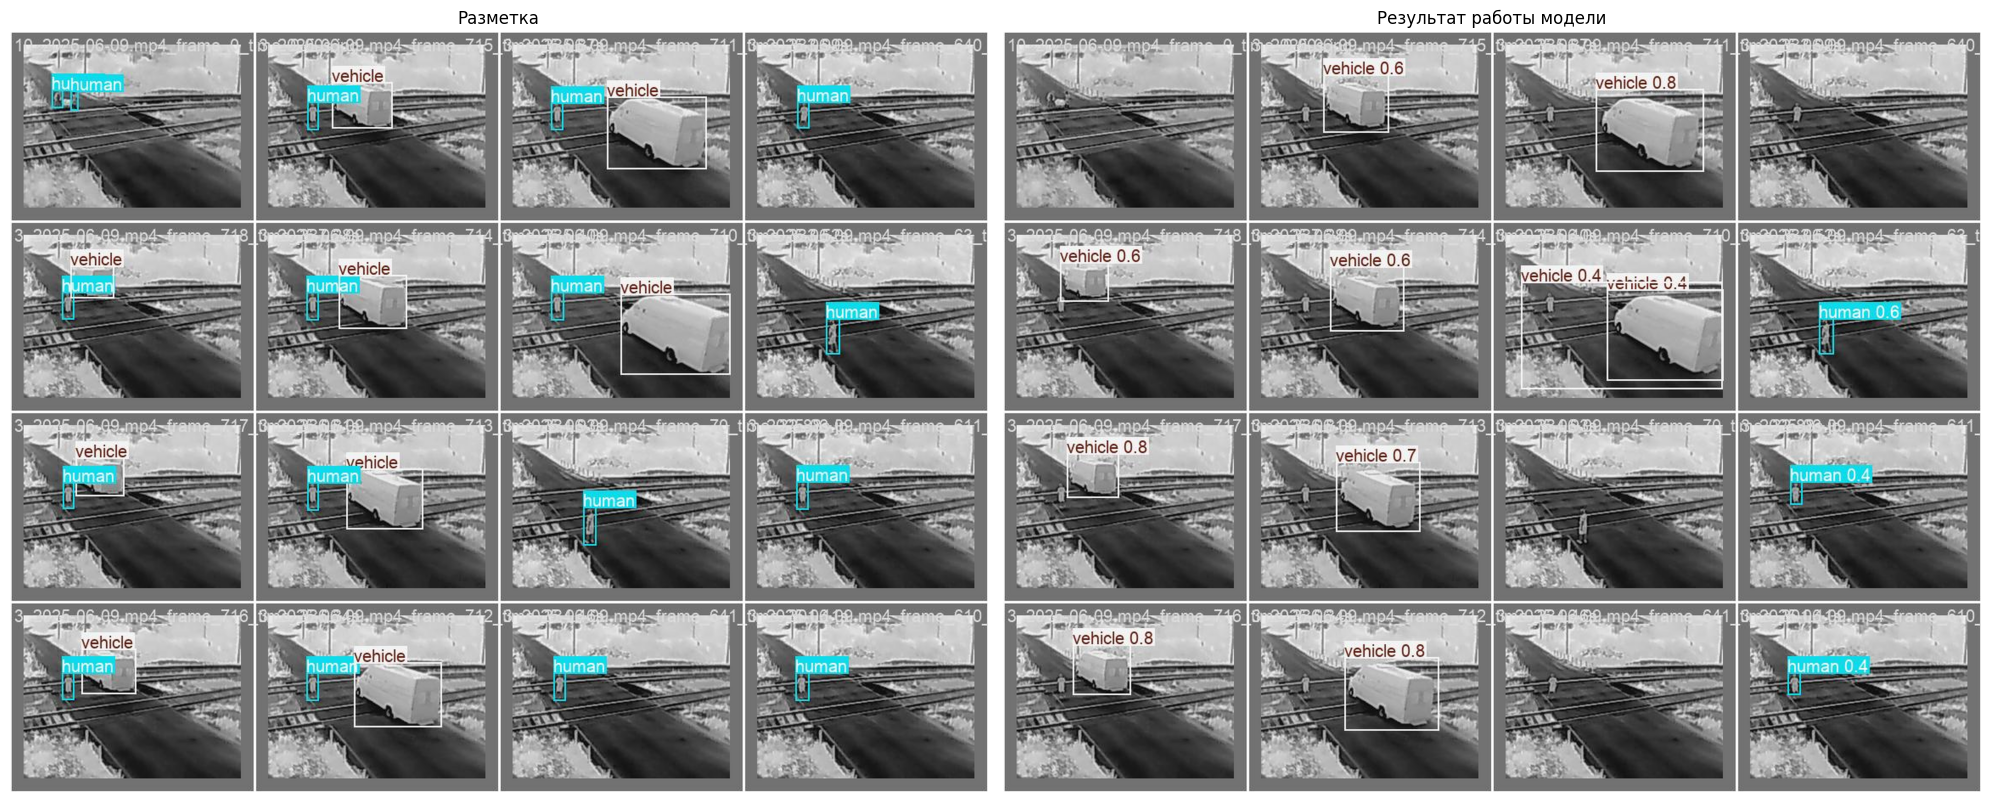

In [60]:
image1 = Image.open('runs/detect/val2/val_batch0_labels.jpg')
image2 = Image.open('runs/detect/val2/val_batch0_pred.jpg')

scale = 3.0
new_width = int(image1.width * scale)
new_height = int(image1.height * scale)

resized_image1 = image1.resize((new_width, new_height), Image.Resampling.LANCZOS)
resized_image2 = image2.resize((new_width, new_height), Image.Resampling.LANCZOS)

fig, axs = plt.subplots(1, 2, figsize=(20, 15))
axs[0].imshow(resized_image1)
axs[0].axis('off')
axs[0].set_title('Разметка')

axs[1].imshow(resized_image2)
axs[1].axis('off')
axs[1].set_title('Результат работы модели')

plt.tight_layout()
plt.show()

- На данном примере видно что модель распознала человека только на 3 кадрах из 16;
- Так же в примере содержится ситуация когда модель определила автомобиль и рядом стоящего человека как один объект класса vehicle

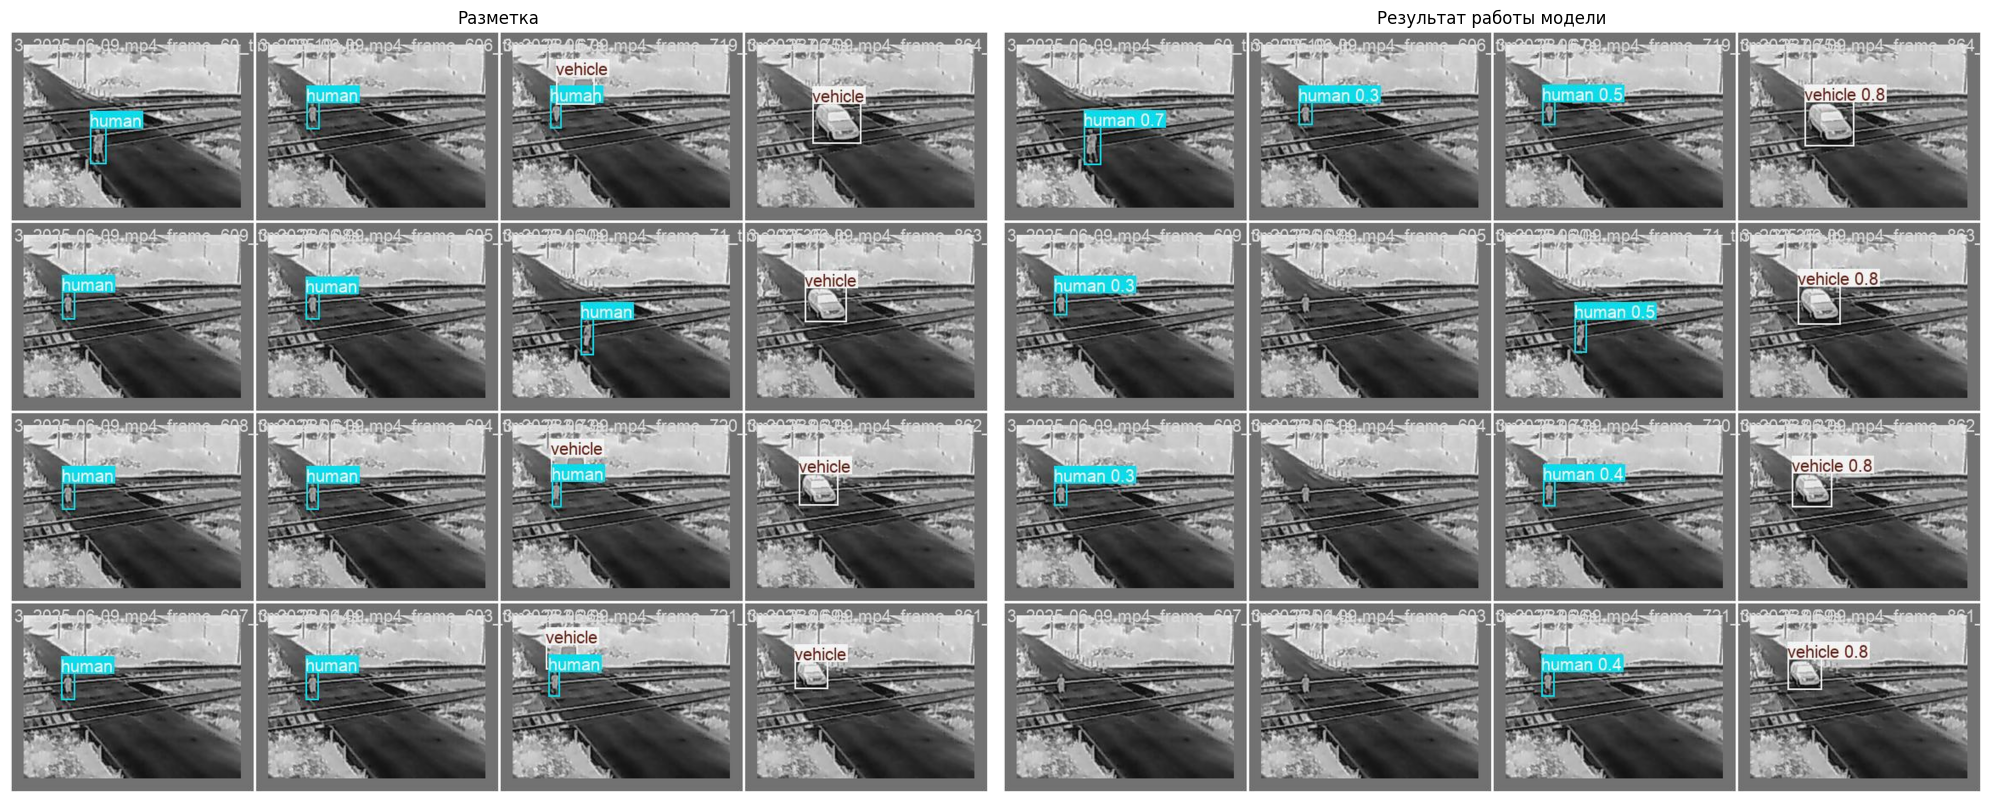

In [61]:
image1 = Image.open('runs/detect/val2/val_batch1_labels.jpg')
image2 = Image.open('runs/detect/val2/val_batch1_pred.jpg')

scale = 3.0
new_width = int(image1.width * scale)
new_height = int(image1.height * scale)

resized_image1 = image1.resize((new_width, new_height), Image.Resampling.LANCZOS)
resized_image2 = image2.resize((new_width, new_height), Image.Resampling.LANCZOS)

fig, axs = plt.subplots(1, 2, figsize=(20, 15))
axs[0].imshow(resized_image1)
axs[0].axis('off')
axs[0].set_title('Разметка')

axs[1].imshow(resized_image2)
axs[1].axis('off')
axs[1].set_title('Результат работы модели')

plt.tight_layout()
plt.show()

- Уверенность при обнаружении объектов, которые относятся к классу vehicle, довольно высокая (0.8);
- В данном примере люди распознаются с низкой уверенностью и можем заметить что человек в разных позах, распознается по разному.

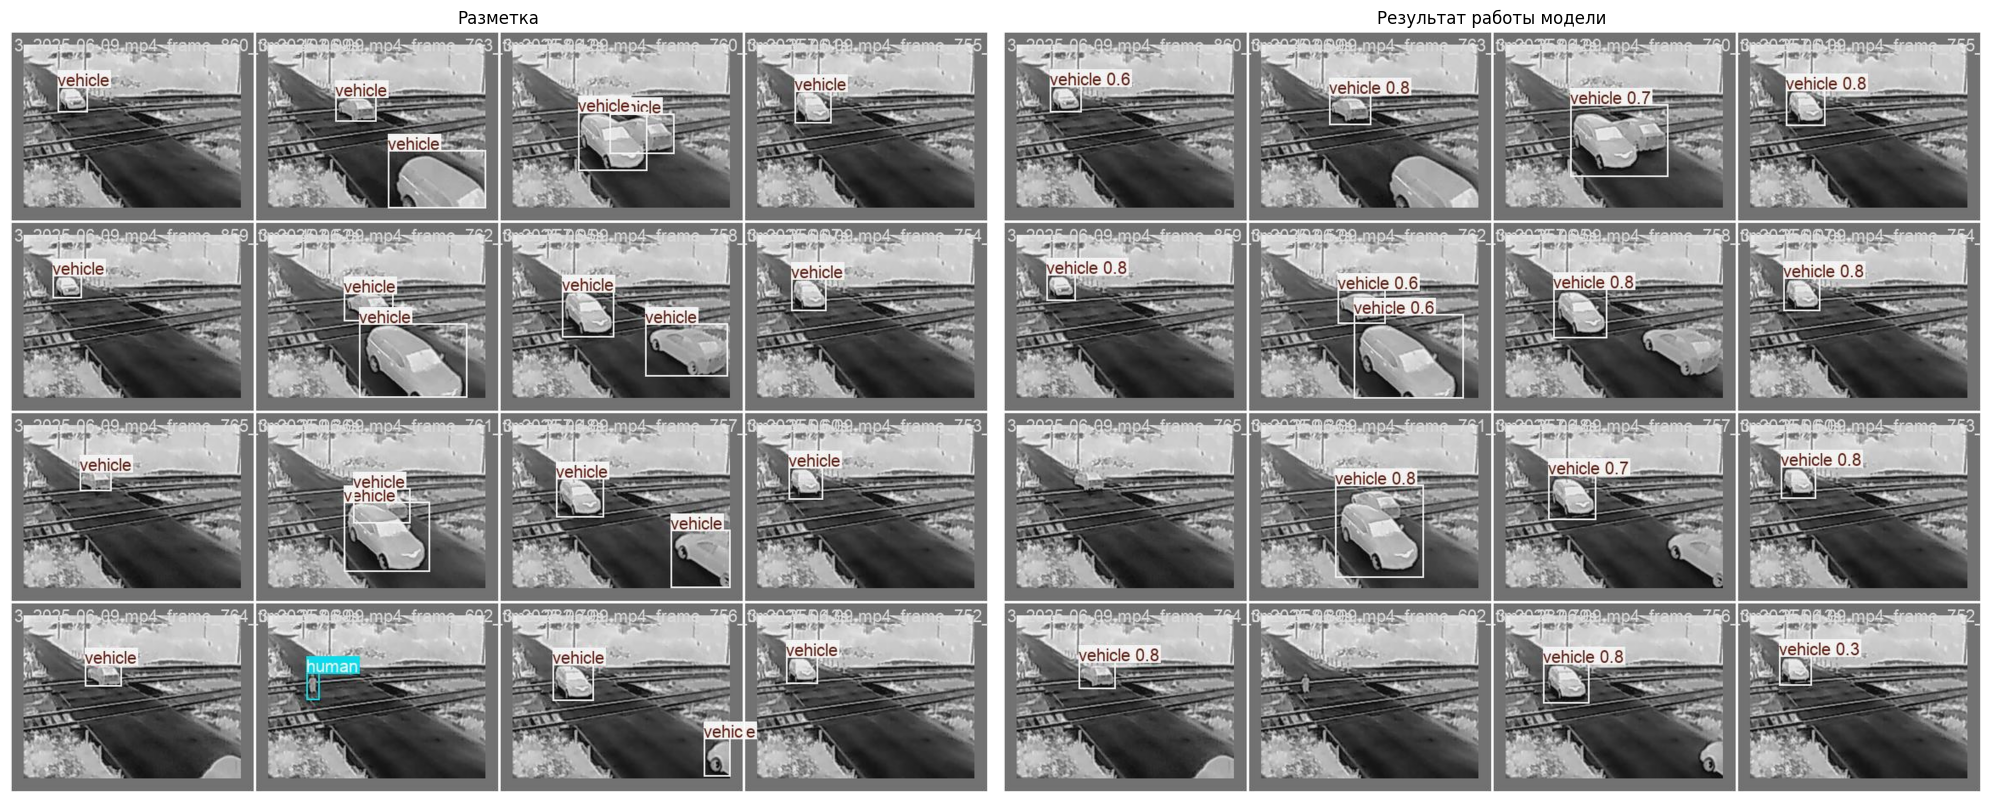

In [62]:
image1 = Image.open('runs/detect/val2/val_batch2_labels.jpg')
image2 = Image.open('runs/detect/val2/val_batch2_pred.jpg')

scale = 3.0
new_width = int(image1.width * scale)
new_height = int(image1.height * scale)

resized_image1 = image1.resize((new_width, new_height), Image.Resampling.LANCZOS)
resized_image2 = image2.resize((new_width, new_height), Image.Resampling.LANCZOS)

fig, axs = plt.subplots(1, 2, figsize=(20, 15))
axs[0].imshow(resized_image1)
axs[0].axis('off')
axs[0].set_title('Разметка')

axs[1].imshow(resized_image2)
axs[1].axis('off')
axs[1].set_title('Результат работы модели')

plt.tight_layout()
plt.show()

### Матрица ошибок

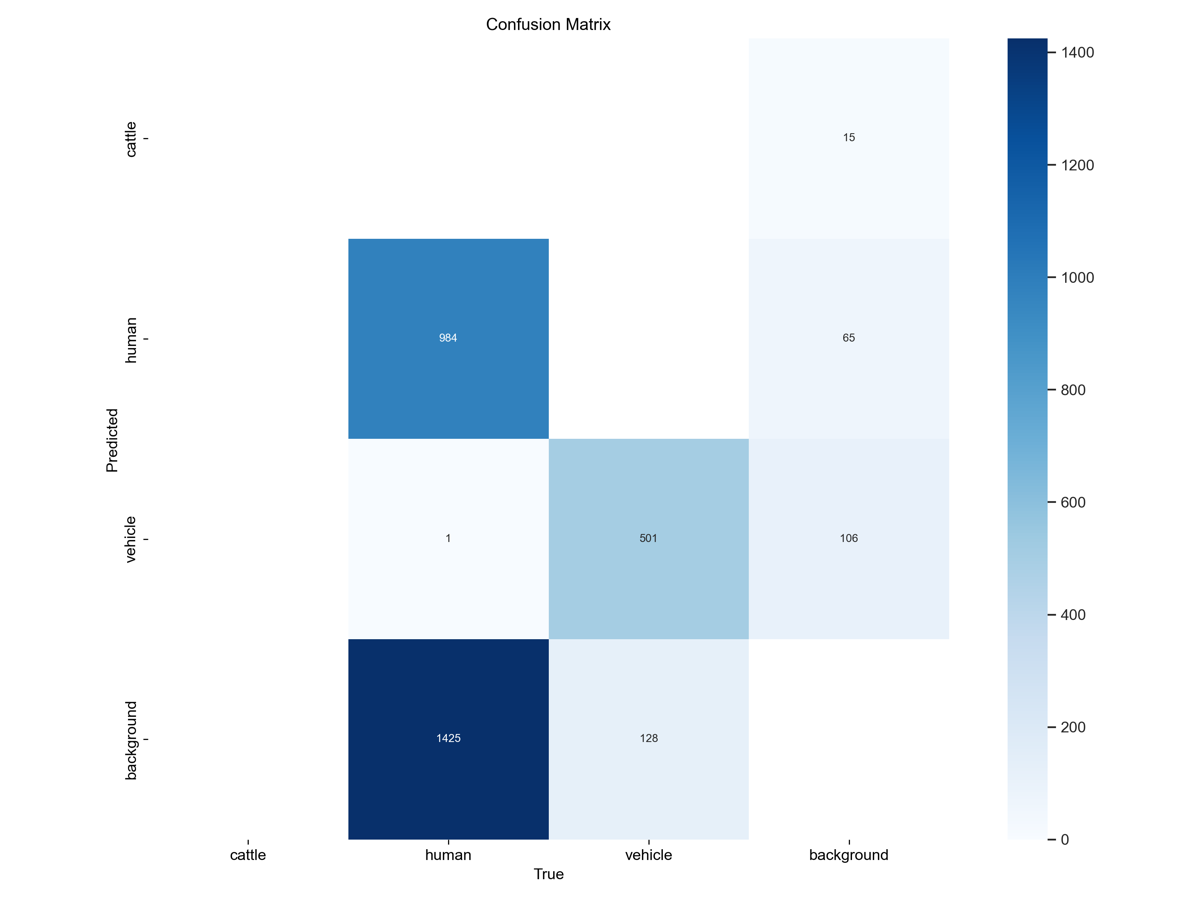

In [26]:
image = Image.open('runs/detect/val2/confusion_matrix.png')
scale = 0.4
new_width = int(image.width * scale)
new_height = int(image.height * scale)

resized_image = image.resize((new_width, new_height))

display(resized_image)

### Метрики

#### Истинно положительные (True Positives, TP): Объекты, которые модель правильно обнаружила и классифицировала.

- human = 984
- vehicle = 501

#### Ложно положительные (False Positives, FP): Объекты, которые модель обнаружила, но на самом деле их нет (ошибка первого рода).

- human = 65
- vehicle = 107

#### Ложно отрицательные (False Negatives, FN): Объекты, которые модель не обнаружила, но они присутствуют на изображении (ошибка второго рода).

- human = 1425
- vehicle = 128

#### Точность (Precision)

$$Precision = \frac{TP}{TP + FP}$$

In [1]:
# Данные для класса human
true_positives_human = 984
false_positives_human = 65

# Данные для класса vehicle
true_positives_vehicle = 501
false_positives_vehicle = 1 + 106

# Вычисление точности для каждого класса
precision_per_class_human = true_positives_human / (true_positives_human + false_positives_human)
precision_per_class_vehicle = true_positives_vehicle / (true_positives_vehicle + false_positives_vehicle)

print(f"Точность для класса human: {precision_per_class_human:.4f}")
print(f"Точность для класса vehicle: {precision_per_class_vehicle:.4f}")

# Вычисление общей точности (macro-averaged precision)
overall_precision = (precision_per_class_human + precision_per_class_vehicle) / 2

print(f"Общая точность для всех классов: {overall_precision:.4f}")

Точность для класса human: 0.9380
Точность для класса vehicle: 0.8240
Общая точность для всех классов: 0.8810


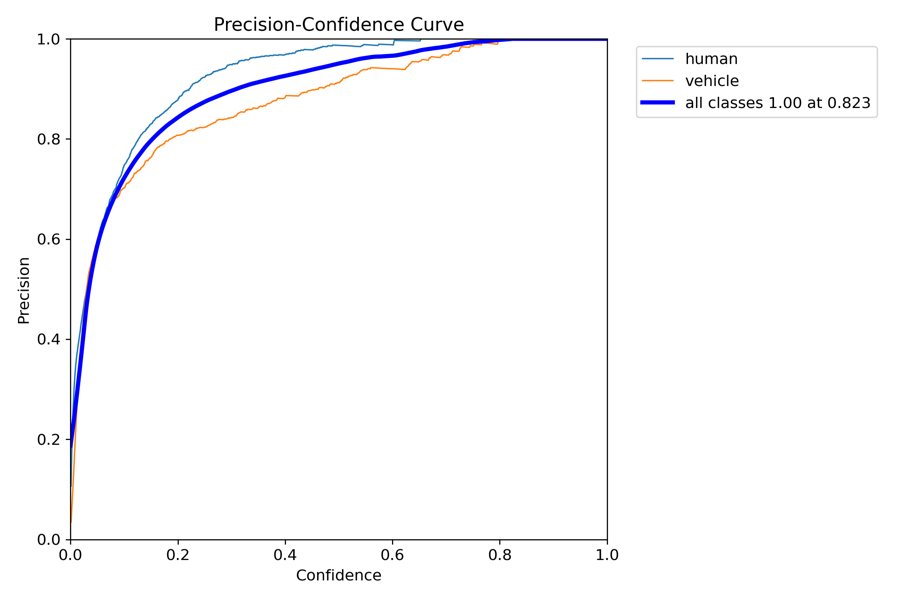

In [44]:
image = Image.open('runs/detect/val2/P_curve.png')
scale = 0.4
new_width = int(image.width * scale)
new_height = int(image.height * scale)

resized_image = image.resize((new_width, new_height))

display(resized_image)

- Высокое значение метрики Точность (Precision), говорит лишь о том что с увеличением уверенности модели резко падает **TP** и **FP**, но растет **FN**
Фактически модель просто не будет дектить объекты

#### Полнота (Recall)

$$Recall = \frac{TP}{TP + FN}$$

In [2]:
# Данные для класса human
true_positives_human = 984
false_negatives_human = 1425 + 1  # False negatives для класса human

# Данные для класса vehicle
true_positives_vehicle = 501
false_negatives_vehicle = 128  # False negatives для класса vehicle

# Вычисление полноты для каждого класса
recall_per_class_human = true_positives_human / (true_positives_human + false_negatives_human)
recall_per_class_vehicle = true_positives_vehicle / (true_positives_vehicle + false_negatives_vehicle)

print(f"Полнота для класса human: {recall_per_class_human:.4f}")
print(f"Полнота для класса vehicle: {recall_per_class_vehicle:.4f}")

# Вычисление общей полноты (macro-averaged recall)
overall_recall = (recall_per_class_human + recall_per_class_vehicle) / 2

print(f"Общая полнота для всех классов: {overall_recall:.4f}")


Полнота для класса human: 0.4083
Полнота для класса vehicle: 0.7965
Общая полнота для всех классов: 0.6024


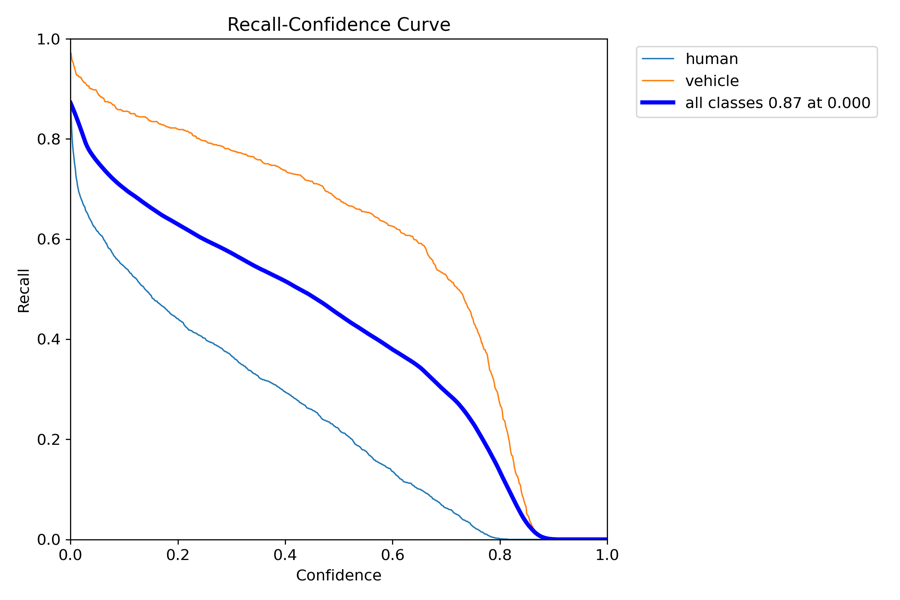

In [43]:
image = Image.open('runs/detect/val2/R_curve.png')
scale = 0.4
new_width = int(image.width * scale)
new_height = int(image.height * scale)

resized_image = image.resize((new_width, new_height))

display(resized_image)

- Можем заметить что класс vehicle более устойчив к увелечению уверенности модели

#### F1-score — это гармоническое среднее между точностью и полнотой
$$F1 = 2×\frac{Precision×Recall}{Precision + Recall}$$

Приемущества метрики F1-score:
- предоставляет единое значение, которое учитывает как точность, так и полноту, что особенно полезно, когда необходимо найти баланс между этими двумя метриками
- позволяет оценить качество модели, особенно в случаях, когда классы несбалансированы. Это важно, так как в таких случаях точность или полнота по отдельности могут давать искаженное представление о качестве модели.

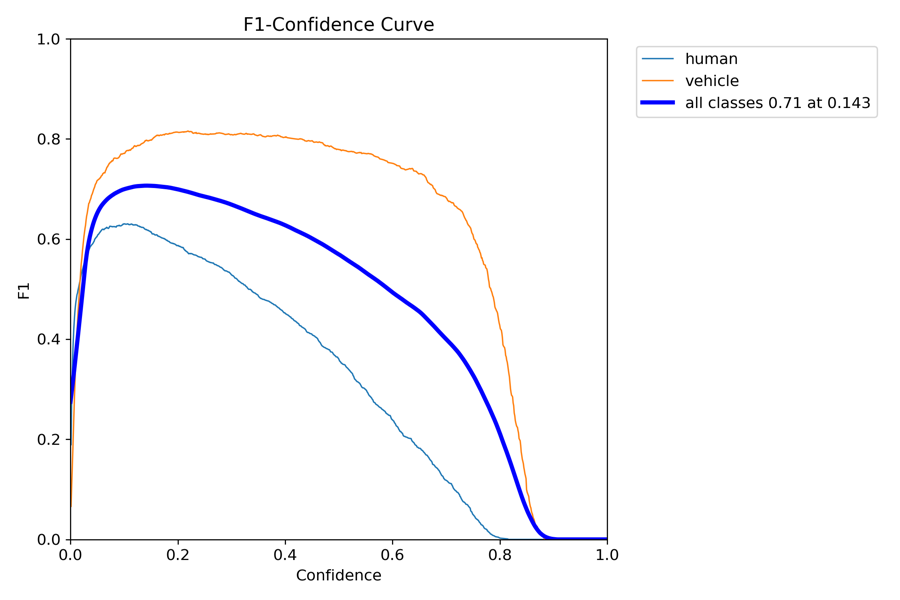

In [45]:
image = Image.open('runs/detect/val2/F1_curve.png')
scale = 0.4
new_width = int(image.width * scale)
new_height = int(image.height * scale)

resized_image = image.resize((new_width, new_height))

display(resized_image)

При анализе графика зависимости метрики F1 от порога уверенности можно заметить, что модель эффективно решает задачи детекции для класса "vehicle" при пороге уверенности 0.7, достигая значения F1 примерно 0.75. Однако для класса "human" производительность модели значительно ниже, с F1 около 0.1. Это связано с тем, что изначально модель была ориентирована на детекцию крупных животных, что отразилось на составе обучающего датасета, который в основном содержал изображения и разметку крупных животных.

Для улучшения модели детекции предлагаются следующие шаги:

- Сбор дополнительных данных для класса "human": Необходимо собрать дополнительный набор изображений с камер комплекса, чтобы дообучить модель для улучшения детекции класса "human". Это поможет повысить точность и полноту для данного класса.

- Обогащение датасета для класса "vehicle": Для класса "vehicle" можно использовать изначальный датасет, но рекомендуется дополнить его изображениями с камер комплекса. Однако объем дополнительных данных для этого класса может быть меньше, чем для класса "human", так как текущая производительность модели для класса "vehicle" уже находится на приемлемом уровне.

Кроме того, для каждого отдельного комплекса рекомендуется обучать специализированную модель на датасете, собранном именно с этого комплекса, чтобы учесть его специфические особенности и условия.